In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import nltk 
import sklearn 
import collections
import sys
import itertools
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm

In [2]:
df_CFPB = pd.read_csv("/content/drive/MyDrive/complaints.csv")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_CFPB.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2021-01-13,Debt collection,I do not know,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,NaN,NaN,OneMain Finance Corporation,FL,33433,NaN,NaN,Web,2021-01-13,In progress,Yes,NaN,4065676
1,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
2,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555


In [5]:
df_narrative = pd.read_csv("/content/drive/MyDrive/narratives.csv")

In [6]:
df_narrative.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Complaint length
0,0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"['transworld', 'system', 'inc', 'try', 'collec...",NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392,18
1,1,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"['past', 'week', 'receive', 'excessive', 'amou...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198,78
2,2,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,"['pioneer', 'commit', 'several', 'federal', 'v...",NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555,152
3,3,2019-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"['previously', 'request', 'experian', 'send', ...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,914XX,NaN,Consent provided,Web,2019-07-26,Closed with explanation,Yes,NaN,3319331,171
4,4,2019-07-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"['hello', 'complaint', 'three', 'credit', 'rep...",Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,109XX,NaN,Consent provided,Web,2019-07-08,Closed with explanation,Yes,NaN,3299394,428


In [7]:
# Number of missing complaint narratives
no_miss_narr = df_CFPB['Consumer complaint narrative'].isnull().sum()
pct_miss_narr = no_miss_narr/len(df_CFPB.index) * 100
print(f"Number of missing complaints without narratives: {no_miss_narr}")
print(f"Percentage of all complaints without narrative: {pct_miss_narr:.2f}%")

del no_miss_narr
del pct_miss_narr
gc.collect()

Number of missing complaints without narratives: 1280833
Percentage of all complaints without narrative: 66.05%


23

In [8]:
# Splitting the dataset into one with narratives and one without
df_CFPB_no_narr = df_CFPB[df_CFPB['Consumer complaint narrative'].isnull()].drop('Consumer complaint narrative', axis=1)
df_CFPB_w_narr = df_CFPB[df_CFPB['Consumer complaint narrative'].notna()]
print(df_CFPB_no_narr.shape)
print(df_CFPB_w_narr.shape)

del df_CFPB
gc.collect()

(1280833, 17)
(658331, 18)


0

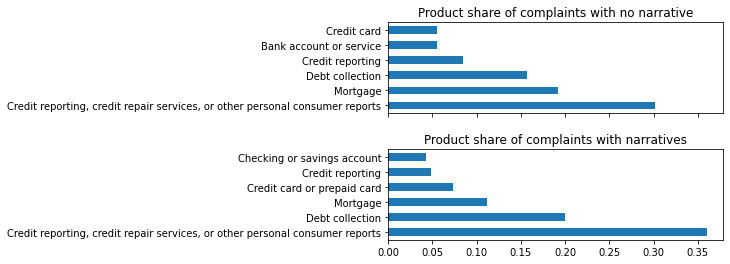

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
no_narr_top_prods = df_CFPB_no_narr['Product'].value_counts(normalize=True).sort_values(ascending=False)[:6]
w_narr_top_prods = df_CFPB_w_narr['Product'].value_counts(normalize=True).sort_values(ascending=False)[:6]
no_narr_top_prods.plot(kind='barh', ax=axes[0])
w_narr_top_prods.plot(kind='barh', ax=axes[1])
axes[0].title.set_text('Product share of complaints with no narrative')
axes[1].title.set_text('Product share of complaints with narratives')
fig.subplots_adjust(hspace=.4)

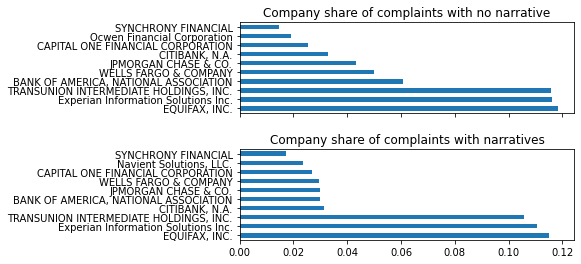

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
no_narr_top_prods = df_CFPB_no_narr['Company'].value_counts(normalize=True).sort_values(ascending=False)[:10]
w_narr_top_prods = df_CFPB_w_narr['Company'].value_counts(normalize=True).sort_values(ascending=False)[:10]
no_narr_top_prods.plot(kind='barh', ax=axes[0])
w_narr_top_prods.plot(kind='barh', ax=axes[1])
axes[0].title.set_text('Company share of complaints with no narrative')
axes[1].title.set_text('Company share of complaints with narratives')
fig.subplots_adjust(hspace=.4)

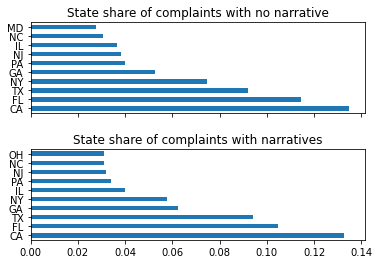

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
no_narr_top_prods = df_CFPB_no_narr['State'].value_counts(normalize=True).sort_values(ascending=False)[:10]
w_narr_top_prods = df_CFPB_w_narr['State'].value_counts(normalize=True).sort_values(ascending=False)[:10]
no_narr_top_prods.plot(kind='barh', ax=axes[0])
w_narr_top_prods.plot(kind='barh', ax=axes[1])
axes[0].title.set_text('State share of complaints with no narrative')
axes[1].title.set_text('State share of complaints with narratives')
fig.subplots_adjust(hspace=.4)

# Sentiment Analysis

In [12]:
pip install nrclex

In [13]:
from nrclex import NRCLex 
import glob
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()

In [14]:
#EQUIFAX_w_narr=df_CFPB_w_narr[df_CFPB_w_narr['Company'].isin(['EQUIFAX, INC.'])==True]
#content=EQUIFAX_w_narr['Consumer complaint narrative'][:100]
#EQUIFAX_w_narr=pd.DataFrame({'narrative': content})
#EQUIFAX_w_narr.head()

In [15]:
EQUIFAX_w_narr=df_narrative[df_narrative['Company'].isin(['EQUIFAX, INC.'])==True]
content=EQUIFAX_w_narr['Consumer complaint narrative']
EQUIFAX_w_narr_subset=pd.DataFrame({'narrative': content})
EQUIFAX_w_narr_subset.reset_index(drop=True, inplace=True)
EQUIFAX_w_narr_subset=EQUIFAX_w_narr_subset[0:50]
EQUIFAX_w_narr_subset

,narrative
0,"['report', 'incorrectly', 'equifax', 'account'..."
1,"['nc', 'equifax', 'attorney', 'general', 'cons..."
2,"['try', 'talk', 'company', 'explain', 'account..."
3,"['send', 'company', 'dispute', 'letter', 'deta..."
4,"['new', 'law', 'effective', 'public', 'record'..."
5,"['woman', 'flesh', 'blood', 'beneficiary', 'ac..."
6,"['ok', 'receive', 'inquiry', 'equifax', 'credi..."
7,"['careful', 'research', 'read', 'fcra', 'law',..."
8,"['recently', 'obtain', 'credit', 'report', 'fi..."
9,"['hi', 'send', 'letter', 'deliver', 'request',..."


# Reading in the EmoLex

In [16]:
filepath = "/content/drive/MyDrive/Practicum/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t', keep_default_na=False)
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
1,abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,abate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=False, 
                      norm='l1')

In [18]:
matrix = vec.fit_transform(EQUIFAX_w_narr_subset.narrative)

In [19]:
vocab = vec.get_feature_names()

In [20]:
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)

In [21]:
wordcount_df.head()

,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,abbreviation,abdomen,abdominal,abduction,aberrant,aberration,abeyance,abhor,abhorrent,abide,ability,abject,ablation,ablaze,abnormal,aboard,abode,abolish,abolition,abominable,abomination,aboriginal,abort,abortion,abortive,abound,abovementioned,abrasion,abroad,abrogate,abrupt,...,yearly,yearn,yearning,years,yeast,yell,yellow,yellows,yelp,yeoman,yesterday,yesteryear,yew,yield,yielding,yogi,yoke,yolk,yon,yonder,young,younger,youth,zany,zap,zeal,zealot,zealous,zebra,zenith,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#wordcount_df.sort_values(by='credit', ascending=False).head(5)

In [23]:
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
1,abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,abate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
emolex_df[emolex_df.anger == 1].head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
2,abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
16,abhor,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
17,abhorrent,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
26,abolish,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
neg_words = emolex_df[emolex_df.negative == 1]['word']
neg_words.head(10)

1         abandon
2       abandoned
3     abandonment
12      abduction
13       aberrant
14     aberration
16          abhor
17      abhorrent
20         abject
23       abnormal
Name: word, dtype: object

In [35]:
wordcount_df[neg_words].head()

,abandon,abandoned,abandonment,abduction,aberrant,aberration,abhor,abhorrent,abject,abnormal,abolish,abolition,abominable,abomination,abort,abortion,abortive,abrasion,abrogate,abscess,absence,absent,absentee,absenteeism,absurd,absurdity,abundance,abuse,abysmal,abyss,accident,accidental,accursed,accusation,accusative,accused,accuser,accusing,ache,aching,...,witchcraft,withdraw,wither,withered,woe,woeful,woefully,words,worm,worn,worried,worry,worrying,worse,worsening,worthless,wound,wrangling,wrath,wreak,wreck,wrecked,wrench,wrestling,wretch,wretched,wrong,wrongdoing,wrongful,wrongly,wrought,wry,xenophobia,yawn,yawning,yearning,yell,yellows,yelp,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
negative_words = emolex_df[emolex_df.negative == 1].word

EQUIFAX_w_narr_subset['negative'] = wordcount_df[negative_words].sum(axis=1)
EQUIFAX_w_narr_subset.head(10)

,narrative,negative
0,"['report', 'incorrectly', 'equifax', 'account'...",0.142857
1,"['nc', 'equifax', 'attorney', 'general', 'cons...",0.184466
2,"['try', 'talk', 'company', 'explain', 'account...",0.083333
3,"['send', 'company', 'dispute', 'letter', 'deta...",0.203125
4,"['new', 'law', 'effective', 'public', 'record'...",0.035714
5,"['woman', 'flesh', 'blood', 'beneficiary', 'ac...",0.104762
6,"['ok', 'receive', 'inquiry', 'equifax', 'credi...",0.213333
7,"['careful', 'research', 'read', 'fcra', 'law',...",0.228571
8,"['recently', 'obtain', 'credit', 'report', 'fi...",0.151515
9,"['hi', 'send', 'letter', 'deliver', 'request',...",0.173913


In [28]:
positive_words = emolex_df[emolex_df.positive == 1].word

EQUIFAX_w_narr_subset['positive'] = wordcount_df[positive_words].sum(axis=1)
EQUIFAX_w_narr_subset.head(10)

,narrative,negative,positive
0,"['report', 'incorrectly', 'equifax', 'account'...",0.142857,0.333333
1,"['nc', 'equifax', 'attorney', 'general', 'cons...",0.184466,0.252427
2,"['try', 'talk', 'company', 'explain', 'account...",0.083333,0.416667
3,"['send', 'company', 'dispute', 'letter', 'deta...",0.203125,0.125000
4,"['new', 'law', 'effective', 'public', 'record'...",0.035714,0.464286
5,"['woman', 'flesh', 'blood', 'beneficiary', 'ac...",0.104762,0.333333
6,"['ok', 'receive', 'inquiry', 'equifax', 'credi...",0.213333,0.466667
7,"['careful', 'research', 'read', 'fcra', 'law',...",0.228571,0.142857
8,"['recently', 'obtain', 'credit', 'report', 'fi...",0.151515,0.272727
9,"['hi', 'send', 'letter', 'deliver', 'request',...",0.173913,0.130435


In [29]:
angry_words = emolex_df[emolex_df.anger == 1]['word']
EQUIFAX_w_narr_subset['anger'] = wordcount_df[angry_words].sum(axis=1)
EQUIFAX_w_narr_subset.head(10)

,narrative,negative,positive,anger
0,"['report', 'incorrectly', 'equifax', 'account'...",0.142857,0.333333,0.047619
1,"['nc', 'equifax', 'attorney', 'general', 'cons...",0.184466,0.252427,0.135922
2,"['try', 'talk', 'company', 'explain', 'account...",0.083333,0.416667,0.083333
3,"['send', 'company', 'dispute', 'letter', 'deta...",0.203125,0.125000,0.046875
4,"['new', 'law', 'effective', 'public', 'record'...",0.035714,0.464286,0.071429
5,"['woman', 'flesh', 'blood', 'beneficiary', 'ac...",0.104762,0.333333,0.047619
6,"['ok', 'receive', 'inquiry', 'equifax', 'credi...",0.213333,0.466667,0.160000
7,"['careful', 'research', 'read', 'fcra', 'law',...",0.228571,0.142857,0.171429
8,"['recently', 'obtain', 'credit', 'report', 'fi...",0.151515,0.272727,0.060606
9,"['hi', 'send', 'letter', 'deliver', 'request',...",0.173913,0.130435,0.043478


In [30]:
pd.options.mode.chained_assignment = None 

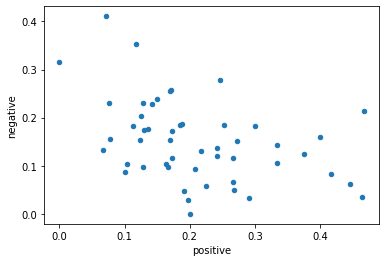

In [31]:
EQUIFAX_w_narr_subset.plot(x='positive', y='negative', kind='scatter')

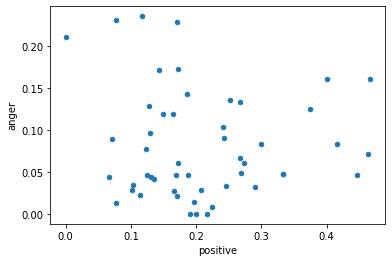

In [32]:
EQUIFAX_w_narr_subset.plot(x='positive', y='anger', kind='scatter')

In [33]:
#EQUIFAX_w_narr['product'] = wordcount_df[['credit', 'debt', 'account', 'mortgage']].sum(axis=1)
#EQUIFAX_w_narr.head(10)

In [34]:
#wordcount_df[['awful', 'dispute', 'bad', 'worse', 'incorrect']].head()